# Project Mobile Robot

(Prof. Francesco Mondada)

Students :  
Roxane Pangaud, Sélim Kamal, Yann Boudigou, Harsh Jaiswal

## Introduction

Our environment is an white open space on which we added black obstacles of random shapes. We found it more interesting to work with random obstacles than already defined ones (squares for example). 

We then use vision to transform the real map into a grid map. We chose to divide the original space of 150cm x 150cm into a squared grid of 50x50, based on the pixels of an image taken by a smartphone. So in the end the space is divided in small squares of 3cm by 3cm.

We also use the vision to find the coordinates of the Thymio and the goal, as well as the angle of the robot.

After that, we use A* algorithm to find a path between the "start" (Thymio) and the "goal" (a green and yellow target).

Finally, we use odometry and local avoidance for the Thymio to navigate in the environment. Since, we regularly update the position of the Thymio with the camera, we are able to change the goal position in the middle of the run.

## Vision

For the Vision part we used our phones since there were not enough cameras for everyone. We downloaded the app IP Webcam to access our phone's cameras and we implemented a live feed in Python in the "get_image" function.

After getting the image we crop it to make it correspond to the area where the robot is moving. Then we estimate if the camera is hidden. To do that we simply put the image in grey scale and compute the average value of it. So if there's a lot of black pixels the mean will be lower and if it's under a certain threshold value, we consider it's obstructed and not useable.

From the image we compute an occupancy grid (i.e. where the obstacles are on the map) which will be used by the A star algorithm. In order to do that we take the cropped image in input, we convert it into a grey scale image because our floor is white and our obstacles are black. Then we resize it to match the grid size we want. Now we have to determine for every pixel if it corresponds to an obstacle or not, and this is done by use a threshold filtering. In the end we just do rearrange the grid to have our axis in the good place and we divide everything by 255 to have only 1 and 0 (1 corresponds to obstacle and 0 to empty space).

To avoid the Thymio from going to close to the obstacles and always be in obstacle avoidance, we decided to artificially make the obstacles bigger. This is done by the expand_grid function. expand_grid modify the occupancy_grid by expanding the obtacles by the number of cell defined in NB_EXP_TURN. Each turn is composed of two phases: one expandation turn where every cell in contact with an obstacle becomes in the state INCUBATION, and one incubation turn where every cell in INCUBATION becomes an EXPANDED cell (equivalent to OCCUPIED, we just use that to plot the difference between original and expended obstacles). We need the incubation turn otherwise the obstacles would just propagate through the whole map.


The function get_data takes in input the cropped image and use template matching to give the position and angle of the robot and the position of the goal.

Initially, the code was run on the camera image to create the template images for goal and the markers on thymio which are used to calculate its position and orientation.( Can be seen in the commented part of GOAL section). This was done by placing the goal at an arbitrary position on the map and cropping this part to obtain the template in the same resolution as the video output from the camera. This is needed as the Template Matching algorithm is sensitive to the size and orientation of the template and the object to find. The same was repeated for the markers on thymio and the images were saved.

Once the templates were saved, the above described part of the code was commented as this is needed to be done only once. The CV2.TM_SQDIFF_NORMED method of template matching was used which checks the norm of squared difference between the template and the actual image to find the target. This method gave the most accurate matching of the template when compared to other methods. The minimum intensity point in the resulting image gives the coordinates where the algorithm finds the target. This point value is converted to the downsized value which corresponds to the grid size used for the A-star planning.

A pink and blue marker are placed on Thymio and found exactly in the same way as described above. Once the position of both markers are found, the corresponding x and y values are used to determine the center of thymio. This is simple as center of the line joining the two markers position gives the approximate position of thymio. For the orientation,the inverse tangent between the vector formed by positions of the markers and the x axis is calculated.

As a result the robot pose as a vector, start and goal positons for the a-star are returned.


### Demonstration of the vision

In [46]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

In [47]:
##### VISION
MAP_SIZE = 50           # size of the grid
max_val = MAP_SIZE

# values used to crop the image given by the camera
X_SIZE = 1600
Y_SIZE = 1600
X_OFFSET = 200
Y_OFFSET = 150

USEABLE_THRESHOLD = 90
OBSTACLE_THRESHOLD = 90
MAX_VAL_RGB = 255

NB_EXP_TURN = 2
EMPTY = 0               # state of the squares of the grid 
OCCUPIED = 1
EXPANDED = 2            # We use those states to enlage the obstacle for the robot to be able to move along them
INCUBATION = 3

In [48]:
def get_image():

    img = cv2.imread('map.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # crop the image to fit the desired grid
    img = img[Y_OFFSET:Y_OFFSET+Y_SIZE,X_OFFSET:X_OFFSET+X_SIZE]
    
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    return img

In [49]:
def get_data(img):
    
    original_height, original_width = img.shape[:2]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    ##################### GOAL ##########################
    
    template_goal = cv2.imread('goal_template_demo.jpg')

    # do the template matching and compute the position of the goal in the grid
    res = cv2.matchTemplate(img,template_goal,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    plt.figure(figsize=(7,7))
    plt.imshow(res)
    plt.title('Goal Template matching Image'), plt.xticks([]), plt.yticks([])
    
    goal = min_loc
    x_goal=int(np.round(goal[0]*MAP_SIZE/original_width))
    y_goal=MAP_SIZE-int(np.round(goal[1]*MAP_SIZE/original_height))
    goal = (x_goal, y_goal)
    #print("Position of the goal [x, y] :", goal)

    ##################### ROBOT ##########################
    
    template_back_point = cv2.imread('back_template_demo.jpg')

    # do the template matching and compute the position of the back point in the image
    res = cv2.matchTemplate(img,template_back_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    back = [min_loc[0], min_loc[1]]
    #print("Position of the back point [x, y] :", back)
    back[1] = original_height-back[1]


    template_front_point = cv2.imread('front_template_demo.jpg')

    # do the template matching and compute the position of the front point in the image
    res = cv2.matchTemplate(img,template_front_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    front = [min_loc[0], min_loc[1]]
    #print("Position of the front point [x, y] :", front)
    front[1] = original_height-front[1]

    ############ Compute pos and orientation ############

    # compute x and y position of the robot in the grid
    x=(back[0]+front[0])/2
    y=(back[1]+front[1])/2
    x=int(np.round(x*MAP_SIZE/original_width))
    y=int(np.round(y*MAP_SIZE/original_height))

    # vector representing the orientation of the robot
    v = [front[0]-back[0], front[1]-back[1]]
    
    # angle of the robot with respect to the x axis
    theta = math.atan2(v[1],v[0])

    robot_pose = [x, y, theta]
    start = (x,y)
    #print("Position of the robot [x, y, theta] :", robot_pose)
    
    return robot_pose, start, goal

In [50]:
def get_occupancy_grid(img):

    # we put in image in grey scale and resize it according to the MAP_SIZE we want
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(grayImage, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
    
    # we do a threshold on the grayscale image to identify obstacles since they're black
    ret,thresh1 = cv2.threshold(resized,OBSTACLE_THRESHOLD,MAX_VAL_RGB,cv2.THRESH_BINARY_INV)
    occupancy_grid = thresh1.copy()
    occupancy_grid = occupancy_grid/MAX_VAL_RGB
    occupancy_grid = np.array(occupancy_grid, dtype=int)
    occupancy_grid = np.flip(occupancy_grid, 0)
    occupancy_grid = occupancy_grid.transpose()
    
    # we expand the obstacles
    occupancy_grid = expand_grid(occupancy_grid)

    occupancy_grid = np.array(occupancy_grid)
    
    return occupancy_grid

In [51]:
def expand_grid(occupancy_grid):
    
    # nb of cell we want to expand each obstacle
    nb_exp_turn = NB_EXP_TURN  
    
    # expand the obstacles grid by adding one obstacle cell at each turn
    for i in range(nb_exp_turn):
        occupancy_grid = expandation_turn(occupancy_grid)
        occupancy_grid = incubation_turn(occupancy_grid)
    
    return occupancy_grid

In [52]:
def expandation_turn(occupancy_grid):
    
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==OCCUPIED or occupancy_grid[i,j]==EXPANDED):
                
                # just some notation (L_col is left column, T_line is top line...)
                # we check if the surrounding cells are in the grid
                if(j==0):
                    L_col = j
                else:
                    L_col = j-1

                if(i==0):
                    T_line = i
                else:
                    T_line = i-1

                if(j==MAP_SIZE-1):
                    R_col = j
                else:
                    R_col = j+1

                if(i==MAP_SIZE-1):
                    B_line = i
                else:
                    B_line = i+1
                
                # some notation again (BL is bottom left cell according to the current cell...)
                TL = [T_line, L_col]
                T = [T_line, j]
                TR = [T_line, R_col]
                ML = [i, L_col]
                MR = [i, R_col]
                BL = [B_line, L_col]
                B = [B_line, j]
                BR = [B_line, R_col]
                
                # contains all the cell to test (i.e. all the cells around the current cell)
                boxes_to_test = [TL, T, TR, ML, MR, BL, B, BR]
                
                for k in boxes_to_test:
                    if(occupancy_grid[k[0],k[1]]==EMPTY):
                        occupancy_grid[k[0],k[1]]=INCUBATION
                        
    return occupancy_grid

In [53]:
def incubation_turn(occupancy_grid):

    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==INCUBATION):
                occupancy_grid[i,j]=EXPANDED
                
    return occupancy_grid

In [54]:
def create_empty_plot(max_val):
    """
    For plotting matters
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [55]:
def plot_occupancy_grid(start, goal, occupancy_grid):
    
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    
    print('The robot position is the green point and the goal is the purple one')

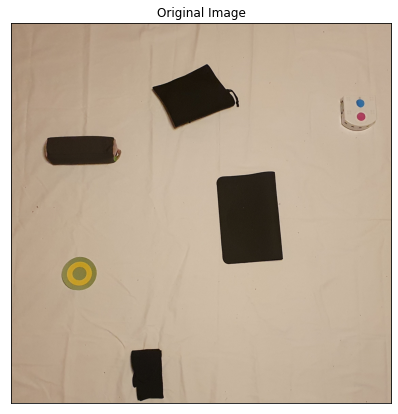

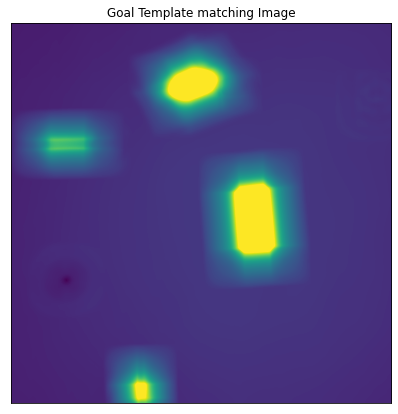

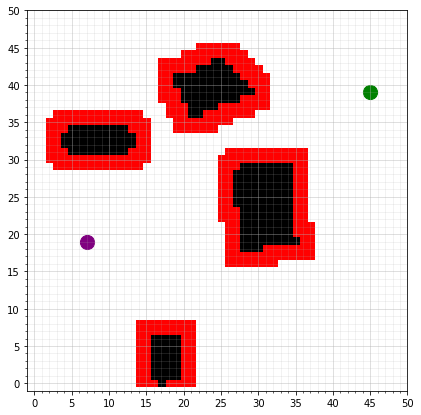

The robot position is the green point and the goal is the purple one


In [56]:
img = get_image()

(robot_pos, start, goal) = get_data(img)

occupancy_grid = get_occupancy_grid(img)

plot_occupancy_grid(start, goal, occupancy_grid)

## Global Navigation

The first thing of our global navigation need is to get the occupancy_grid through our vision functions. This would gives a us a grid with all the cells that the robot cannnot be over because they are occupied or too close to an occupied cell for Thymio's width. 
And for this, the first step is to take a picture of the start situation.

When we do that, we need to make sure the camera wasn't obstructed and so we can have a valid grid. Otherwise our program won't work. Wether or not the camera was obstructed is in the useable boolean so we raise the following exception below

Once this is done, if to Exception were raised, then we can proceed to get the actual occupany_grid which will be 50 by 50 according to the global variables that we set up before.

When this is done, we want to obtain the robot's position as well as the goal's position and then run an astar algorithm in order to find the best path between them. This path is finally given to our motion control module which will follow the given path while avoiding not-anticipated local obstacles. The astar algorithm will be implemented using the ressources given in exercise 5.

But in order to be able to detect a change of the goal's position that would mean the need of a new route and so a new application of the a star argument, we made sure our main motion control function(go_to_goal()) will return a true boolean if it achieved its purpose(reach the goal) or a false boolean if it has detected a change in the goal's position. And then we put this function in a while loop that makes sure everytime the go_to_goal function returns a false boolean, we get all the needed datas again and run a new astar algorithm with them. 

### Demonstration of path planning

In [57]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),]

In [58]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [59]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val=MAP_SIZE):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [60]:
def findroute(start, goal, occupancy_grid):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes

In [61]:
def plot_map(visitedNodes, path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return  fig_astar, ax_astar

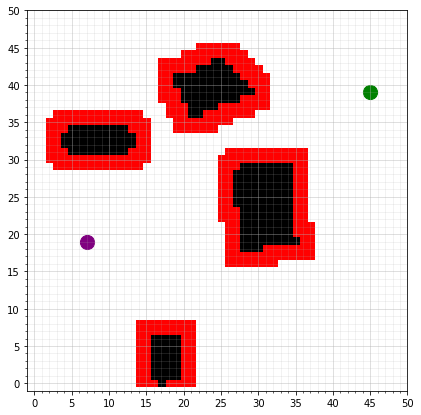

The robot position is the green point and the goal is the purple one


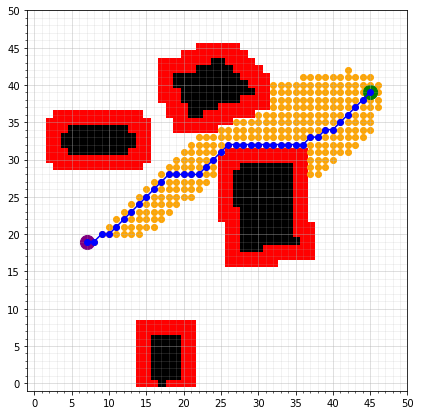

The blue dots represents the chosen path and the yellow ones all the explored nodes


In [62]:
#Display datas for analysis
plot_occupancy_grid(start, goal, occupancy_grid)

#Run the path planning algorithm
path, visitedNodes = findroute(start, goal, occupancy_grid)

#Display the result
(fig_astar, ax_astar) = plot_map(visitedNodes, path, start, goal, occupancy_grid)
print('The blue dots represents the chosen path and the yellow ones all the explored nodes')

## Local navigation 

Local navigation is mainly about local avoidance. To do the local avoidance, we must first be familiar with the sensor. After some test on multiple surfaces, we come to a threshold number of 3800 (PROXIMITY_THRESHOLD) which correspond approximatively of 2cm.

So we created a function called "check_avoidance" that check if one of the sensors measures more than this threshold and returns 1 if it's the case. That means that there is something close to the front of the Thymio and we should go into the avoidance function.

One more specificity is that we don't consider the value of the sensors of the back (the 5th and 6th) because we use the cable to communicate with the robot.

For the avoidance specifically, we tried to implement 2 algorithm. The frist one was working with artificial neural network and the second one was working with conditions (basically: if, elseif, ...). We saw how the 2 algorithm were reacting and choose to continue with the conditional one, because it worked faster and was more reactive.

So after seeing an obstacle, the robot behaves like so:  
1) While the Thymio see the obstacle, it turns in the direction that requires the less rotation (it turns away from the side that see the most the obstacle)  
2) When it don't see it anymore, the robot continues to go forward a little bit to move away from the obstacle (DISTANCE_AVOIDANCE)  
3) Then, to avoid going back to the obstacle, we change the target by taing 8 (OFFSET_TARGET) target further in the id_target for the path of the A* list.  
4) Finaly, we get the position and the angle of the robot by the camera to update our code (we don't run odometry while avoiding an obstacle)

Here are the variables for the local avoidance, were TIME_SLEEP_OBSTACLE is used to add some time between 2 check in the point (1) :

The implementation of this algorithm in our code can be partially seen in the "robot_turn" function above. While the robot is turning or going forward, we constantly check if we see an obstacle with the "check_avoidance" function. If it sees one, a flag *obstacle_seen*, which is also an output of the function, turns to 1. And then we avoid the obstacle with the "avoid_obstacle" function that you see just below.

This function measure the state of the Thymio's sensors and while the obstacle is seen, it sends it to "obstacle_avoidance", which is basically the conditionnal algorithm coupled with some communication functions to make the robot move.

Then we use the "robot_move_forward" function to make the robot move forward for DISTANCE_AVOIDANCE (15cm) and stop the robot, the time we get informations from the camera.

After all that, we return to the main function "go_to_goal" that set the offset for the target and get the informations from the camera to update the Thymio parameters. Here is a part of the "go_to_goal" function that we are interested in for local avoidance:

## Motion Contol

For the motion control, we got inspired by the odometry done in the 6th exercise session. We first calibrate the Thymio, to understand what time it needed for turning 360 degrees. We tried to turn the Thymio and stoped at 340°, we then measured the time. With those data, we used rule of tree and tried to turn the Thymio in different angle. After some time tunning, it was good enough for our application. 

After that, we did the same for the robot's advance by measuring how much it advances for a certain amount of time.

Here are the global variable used for odometry and more generally the motion:

In [63]:
## Global Variable for odometry
CALIBRATION_TIME_ANGLE = 9.6
CALIBRATION_ANGLE = 340
CALIBRATION_TIME = 3.47 # time needed to do the DISTANCE_CALLIBRATION
DISTANCE_CALIBRATION = 10.7

## Global variable for motion
COTE_CARRE_MAP = 150 / MAP_SIZE  # MAP_SIZE = 50, the nb of squares in the rows or colomns (it's a squared map) of the map                                      # and 150 is the side in cm of our environment

With this done, we created a function called "robot_evaluation" that need the position and the angle of the robot, as well as the position of the curent target and it returns *gamma*, the angle that the robot must turn to be aligned with the target in degrees, *direction* ("left","right" or "forward"), which indicate wich direction to turn and *distance*, the distance between the Thymio and the target (in cm). To calculate all of this, we use trigonometry for the different cases of relative positions between the Thymio and the target.

After that, we have all what we need to make the robot move. We implemented then 2 functions in order to move the Thymio: "robot_turn" and "robot_move_forward". The first one takes *gamma*, *direction* and the angle of the robot (*alpha*) and moves it in the direction and the angle (*gamma*) desired, then it changes *alpha*, regarding of how much it thinks the Thymio has moved (*gamma*). The direction changes also to "forward" since we now are aligned with the target. The second one makes the Thymio move forward. The function takes *distance* and the curent position of the robot and the target, and then move the robot forward by *distance* centimeters. Then it updates the position of the Thymio by saying that it is now on the target (target position = robot position).

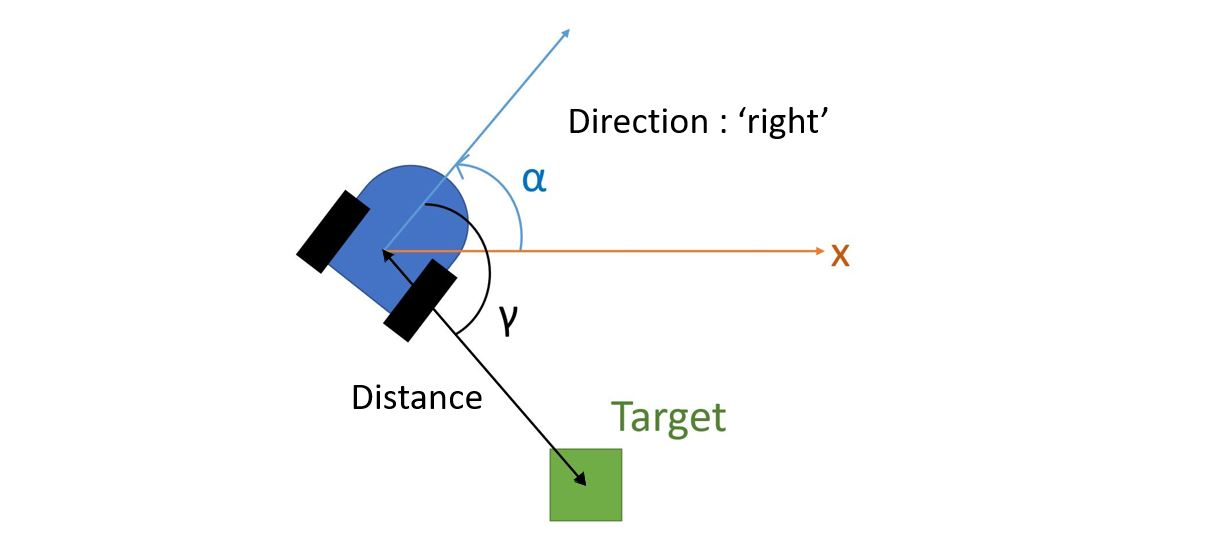

With those displacement functions, we need to use local avoidance, in the case the Thymio meet an unexpected obstacle. This will be explained in the next chapiter. Here is the robot_turn funtion for you to see how it is implemented.

Now, let's talk about our main function "go_to_goal" that controls all the program and thus the motion too :

This is our big function just beside the main function and deal with robot in order to reach the goal (last target of the *taget_list* list). 
First, we start with the initialisation with "get_image" and check if there is an image or someone is clogging it. Then, while we are not aiming for the goal, we :  
1) Check if the goal has moved (this will return false if the goal moved, in order for the main to compute the new global path)  
2) Update the robot's position and angle using camera informations if it's the time (every 3 target)  
3) Move the Thymio to the next target  
    3.1) Find *gamma, direction, distance*  
    3.2) Turn toward target (while dealing with local avoidance as explained before)  
    3.3) Go towards target (while dealing with local avoidance as explained before)  
    3.4) Update *id_taret* if an obstacle is met  
4) Increment *id_target* by 1 to aim at the next point in the route  
5) Plot the position of the robot along the path if needed  

When we reach the end, the Thymio stops and the function returns 1.

### Demonstration of path following

In [64]:
import time
from IPython.display import display, clear_output

In [65]:
def robot_turn(gamma, direction,alpha): #return alpha, direction, obstacle_seen (bool: 0->free)
    #This function makes the robot turn the desired angle
    #This is done by making it turn a calibrted time so given its speed, it's equivalent to the desired angle
    gamma = abs(gamma)
    time_turn = CALIBRATION_TIME_ANGLE*gamma/CALIBRATION_ANGLE
    obstacle_seen = 0
    
    if direction == "right":
        #robot.set_var("motor.left.target", MOTOR_SPEED)
        #robot.set_var("motor.right.target", int(int(2**16)-MOTOR_SPEED))
        t0 =time.time()
        t1 = time.time()
        while t1-t0 < time_turn :
        #    if (check_avoidance()) :
        #        obstacle_seen = 1
        #        avoid_obstacle()
        #        return alpha, direction, obstacle_seen
            t1 = time.time()
        
        alpha = angle_between_pi(alpha-math.radians(gamma))
        
    if direction == "left":
        #robot.set_var("motor.left.target", int(int(2**16)-MOTOR_SPEED))
        #robot.set_var("motor.right.target", MOTOR_SPEED)
        t0 =time.time()
        t1 = time.time()
        while t1-t0 < time_turn :
        #    if (check_avoidance()) :
        #        obstacle_seen = 1
        #        avoid_obstacle()
        #        return alpha, direction, obstacle_seen
            t1 = time.time()
        
        alpha = angle_between_pi(alpha+math.radians(gamma))
    
    direction = "forward"
    
    robot_stop()
    
    return alpha, direction, obstacle_seen

In [66]:
def angle_between_pi(angle): #return angle in [-pi,pi]
    if angle > math.pi :
        angle = angle - 2*math.pi
        return angle
    elif angle < -math.pi:
        angle = angle + 2*math.pi
        return angle
    else :
        return angle

In [67]:
def robot_move_forward(distance,xr,xt,yr,yt): # distance is in cm, returns new xr, yr, obstacle_seen (bool:0->free)
    
    obstacle_seen = 0
    time_forward = CALIBRATION_TIME*distance/DISTANCE_CALIBRATION
    
    #output values to the motor so the robot will move forward at the desired speed
    #robot.set_var("motor.left.target", MOTOR_SPEED)
    #robot.set_var("motor.right.target", MOTOR_SPEED)

    t0 =time.time()
    t1 = time.time()
    #Make sure the robot only moves forward for a time that given the speed set
    #will assure the robot moved of the desired distance
    while t1-t0 < time_forward :
    #    if (check_avoidance()) : #While the robot is moving forward check for obstacles
    #        obstacle_seen = 1
    #        avoid_obstacle()     #If an obstacle is seen, avoid it
    #        return xr, yr, obstacle_seen
        t1 = time.time()
    
    #update robot's position assuming he properly reached the target
    xr=xt 
    yr=yt
    
    #Stop the robot
    robot_stop()
    return xr, yr, obstacle_seen

In [68]:
def robot_stop() :
    #Stop the robot when needed
    
    #robot.set_var("motor.left.target", 0)
    #robot.set_var("motor.right.target", 0)
    return

In [69]:
def robot_evaluation (xr,xt,yr,yt, alpha): #return gamma in degrees, direction, distance in cm
    #This function is based on cases separation and gives a predefined output given the situation
    
    alpha = math.degrees(alpha)
    xr=xr*COTE_CARRE_MAP
    xt=xt*COTE_CARRE_MAP
    yr=yr*COTE_CARRE_MAP
    yt=yt*COTE_CARRE_MAP
    
    if yt>yr and xt<xr :
        gamma = math.degrees(math.atan2(yt-yr,xr-xt))

        if alpha<=0 :
            gamma = gamma + 180+alpha

            if gamma < 180 :
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma - alpha

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt<xr :  
        gamma = math.degrees(math.atan2(yr-yt,xr-xt))

        if alpha>=0 :
            gamma = gamma +180-alpha

            if gamma < 180 :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma + alpha

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt>xr :  
        gamma = math.degrees(math.atan2(yr-yt,xt-xr))

        if alpha>=0 :
            gamma = gamma + alpha

            if gamma > 180 :
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = -alpha - gamma

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        

    if yt>yr and xt>xr :
        gamma = math.degrees(math.atan2(yt-yr,xt-xr))

        if alpha<=0 :
            gamma = gamma - alpha

            if gamma > 180 :
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = alpha - gamma

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
    
    
    if yt==yr and xt>xr :
        gamma = 0
        distance = xt-xr
        
        if abs(alpha)< FOURCHETTE :
            
            #robot move forward
            return abs(gamma), "forward", distance
        elif alpha < -(FOURCHETTE/2) :
            #robot turn left
            return abs(alpha), "left", distance
        else :
            #robot turn right
            return abs(alpha), "right", distance
            
    if yt==yr and xt<xr :
        gamma = 180
        distance = xr-xt

        if alpha < 0 :
            gamma = gamma + alpha
            #robot turn right
            return abs(gamma), "right", distance
        else:
            gamma = gamma - alpha
            #robot turn left
            return abs(gamma), "left", distance
            
    
    if yt<yr and xt==xr :
        gamma = 90                           #=-90
        gamma = gamma+alpha
        distance = yr-yt

        if gamma < 0:
            #robot turn left
            return abs(gamma), "left", distance
        elif gamma > 180 :
            #robot turn left
            gamma= 360-gamma
            return abs(gamma), "left", distance
        else:
            #robot turn right
            return abs(gamma), "right", distance
            
            
    if yt>yr and xt==xr :
        gamma = 90
        gamma = gamma-alpha
        distance = yt-yr

        if gamma < 0 :
            #robot turn right
            return abs(gamma), "right", distance
        elif gamma > 180 :
            #robot turn right
            gamma= 360-gamma
            return abs(gamma), "right", distance
        else:
            #robot turn left
            return abs(gamma), "left", distance

In [70]:
def target_not_reach(xr,yr, target_list, id_target): # return bool yes/no
    #get target's position
    xt = target_list[0][id_target]
    yt = target_list[1][id_target]
    
    #then compare it to the robot's position
    if yt==yr and xt==xr :
        return False
    else:
        return True

In [71]:
def go_to_goal(target_list,occupancy_grid, fig_astar, ax_astar, robot_pos):

    offset = 0
    id_target = 1
    
    alpha = robot_pos[2]

    #While we are not aiming at the last point of the route :
    while (id_target) < (len(target_list[0])) :
        #We check if the goal has moved
        if((goal[0] != target_list[0][len(target_list[0])-1]) or (goal[1] != target_list[1][len(target_list[1])-1])):
            return False #Return false if the goal moved so the main will recompute the global route

        #If the current point we're aiming at is not reached :
        while (target_not_reach(robot_pos[0],robot_pos[1],target_list, id_target)):
            
            #we calculate how and how much it should move
            gamma, direction, distance = robot_evaluation (robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target], alpha)
            
            #then turns toward target
            alpha, direction, obstacle_seen = robot_turn(gamma, direction, alpha)
            
            #finally , once we are aligned, it goes towards target
            if direction == "forward":
                robot_pos[0], robot_pos[1], obstacle_seen = robot_move_forward(distance,robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target])
                #if he saw an obstacle while turning and avoided it
            
            #Actually skip the next few(OFFSET_TARGET) points in the route that are probably obstructed by an obstacle
            if id_target+offset < len(target_list[0])-1 :
                id_target = id_target + offset
                offset = 0
            else :
                id_target = len(target_list[0])-1
        
        #When the target is reached we increment id_target by 1 to aim at the next point in the route
        id_target = id_target + 1
        
        #and finally we plot the position of the robot along the path
        start=(robot_pos[0],robot_pos[1])       
        plot_step(path, start, goal, occupancy_grid,  fig_astar, ax_astar)
    
    #When the final goal is rached, we stop the robot
    robot_stop()
    return True

In [72]:
def plot_step(path, start, goal, occupancy_grid, fig_astar, ax_astar):
    clear_output(wait = True)
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return

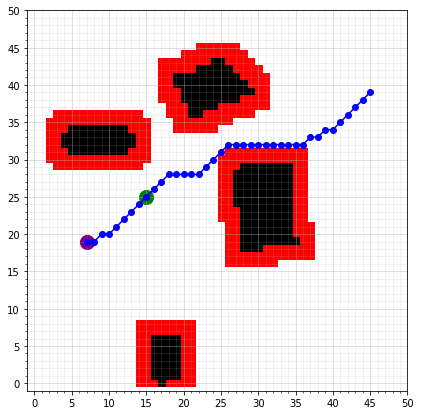

In [ ]:
go_to_goal(path, occupancy_grid,  fig_astar, ax_astar, robot_pos)

## All code and plotting

Run this file to see in each section the plots.

## Conclusion

Our robot is able to achieve the goal of the project by executing the different sections successfully: we continuously process the images taken by the camera, we process it into an occupancy grid in order to perform the A* algorithm. Thanks to the optimal path computed and the local avoidance, we can efficiently avoid all the obstacles. We manage our way to the goal by combining the odometry and the camera localisation to keep track of the robot position along the path.

The Thymio is also capable to find another goal if we change its position and can even reach the goal if we hide the camera. 

However, we didn't implement filtering algorithm because of time, but we managed to use the camera update for the odometry to be more precise and we obtained satisfactory results.

Due to certain difficulties faced because of the pandemic situation, we lost some time and had more difficulties to work together (share screen bugs, micro issues, ...). Moreover, we couldn't meet in the beginning due to quarantine.